In [1]:
# dependencies

import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import seaborn as sns
from textblob import TextBlob
import matplotlib.pyplot as plt

## Getting Started
1. Load dependencies
2. Load data [here we use CSV]

In [2]:
# load the data
DATA_SOURCE = "my_library.csv"
data = pd.read_csv(DATA_SOURCE, memory_map=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551 entries, 0 to 550
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   item ID (Read-Only)   551 non-null    object 
 1   original ID           40 non-null     object 
 2   type                  551 non-null    object 
 3   created (Read-Only)   551 non-null    object 
 4   updated (Read-Only)   551 non-null    object 
 5   read                  551 non-null    bool   
 6   notes                 23 non-null     object 
 7   color                 74 non-null     object 
 8   flag                  551 non-null    bool   
 9   ratings               0 non-null      float64
 10  doi                   532 non-null    object 
 11  patent_id             0 non-null      float64
 12  pmid                  504 non-null    float64
 13  pmcid                 198 non-null    object 
 14  arxiv                 1 non-null      float64
 15  file (Read-Only)      4

### Problem 1
Some articles do not have an abstract

In [19]:
data["abstract"]

# paper = data.loc[data['title'] == "Mitochondrial metabolism promotes adaptation to proteotoxic stress"]
# paper.doi

# paper = data.loc[data['title'] == "BAX-dependent mitochondrial pathway mediates the crosstalk between ferroptosis and apoptosis"]
# paper.doi


0                                                    NaN
1                                                    NaN
2                                                    NaN
3                                                    NaN
4                                                    NaN
                             ...                        
546    Drug hunters are moving into the clinic with h...
547    Human ALS/FTD patient iPSC-derived neurons are...
548    Developments in computational omics technologi...
549    With an ever-increasing amount of (meta)genomi...
550    We have used pulse-chase labeling of Chinese h...
Name: abstract, Length: 551, dtype: object

In [14]:
data.columns

Index(['item ID (Read-Only)', 'original ID', 'type', 'created (Read-Only)',
       'updated (Read-Only)', 'read', 'notes', 'color', 'flag', 'ratings',
       'doi', 'patent_id', 'pmid', 'pmcid', 'arxiv', 'file (Read-Only)',
       'year', 'Library URL', 'PDF URL', 'title', 'author', 'journal', 'date',
       'tags', 'journal abbreviation', 'issn', 'abstract', 'issue', 'volume',
       'pages', 'language', 'url', 'source_url', 'editor', 'isbn',
       'library catalog', 'access date', 'series editor', 'publication title',
       'publisher', 'citekey'],
      dtype='object')

## Clean up
Cleanup the data. For this demo we will only be using the title and abstract

In [20]:
import gc
df = data[['title','abstract', 'doi']]
del data
gc.collect()

df.dropna(inplace=True)
df.drop_duplicates(subset=['abstract'],inplace=True)

/Users/uri/Desktop/Projects/JCARLO/venv/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


/Users/uri/Desktop/Projects/JCARLO/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/uri/Desktop/Projects/JCARLO/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until


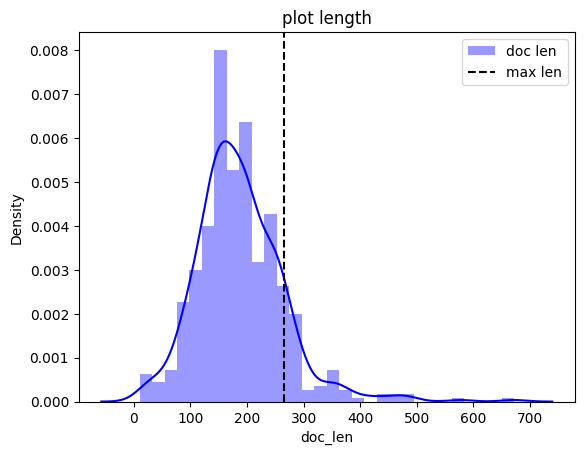

In [21]:
df['doc_len'] = df['abstract'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
sns.distplot(df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

## Chose a Model
This is probably one of the most critical steps: chose a good model that represents the task at hand. First we he to consider between:
1. Symmetric search
2. Asymmetric search

Because we want to search through a pool of large passages we will chose assymetric search. There are plenty of models in this group which are also tunes for different types of searches: euclidian distance, dot-plot, cosine-similiarity.

**Disclosure**: I dont' understand the difference between search approaches so I will be using a trivial dot-plot search approach.

**Todo**: Investigate the type of similarities (cosine, dot-plot, euclidian distance)

In [2]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('msmarco-distilbert-base-v4')

In [23]:
from tqdm.auto import tqdm
tqdm.pandas()

def get_embeddings(documents):
    sentences  = [documents]
    sentence_embeddings = model.encode(sentences)
    encod_np_array = np.array(sentence_embeddings)
    encod_list = encod_np_array.tolist()
    return encod_list[0]

In [24]:
df['vector'] = df['abstract'].progress_apply(get_embeddings)

  0%|          | 0/498 [00:00<?, ?it/s]

/Users/uri/Desktop/Projects/JCARLO/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Start ElasticSearch server
There are alternatives to using the elasticsearch server. But for convenience and the purposes of this demo I'll be using a local elasticsearch server.

We go ahead and start the server and establishing the connection.

In [3]:
from elasticsearch import Elasticsearch

es = Elasticsearch(
    "https://localhost:9200/",
    basic_auth=("elastic", "Z1*nfDFd1YhmgLg8w1qo"),
    ca_certs="/Users/uri/Desktop/Dev/elasticsearch-8.10.4/config/certs/http_ca.crt"
)

es.ping()

True

## Creating an index mapping for elasticsearch



```
index_mapping = {
    "properties": {
        "title": {
            "type": "text"
        },
        "abstract": {
            "type": "text"
        },
        "doc_len": {
            "type": "long"
        },
        "vector": {
            "type": "dense_vector",
            "dims": 768,
            "index": True,
            "similarity": "cosine"
        }
    }
}
```

In [37]:
from indeces_elastic.mapping_msmarco_distilbert_base_v4_v2 import index_mapping

es.indices.create(index="papers2", mappings=index_mapping)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'papers2'})

## Store data in ElasticSearch

After creating the mapping we can the store our data in the server

## Note: Index Paper should be re-created

In [40]:
elk_data = df.to_dict("records")

for record in elk_data:
    try:
        es.index(index="papers2", document=record)
    except Exception as e:
        print(e)

In [41]:
es.count(index="papers2")

ObjectApiResponse({'count': 498, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}})

## Setup is Complete

Now we just need to setup the search query and extract the results

In [333]:
input_kw = "Copper inhibits FDX1-mediated protein lipoylation"
input_embedding = model.encode(input_kw)

query = {
    "field": "vector",
    "query_vector": input_embedding,
    "k": 10,
    "num_candidates": 500
}

res = es.knn_search(index="papers2", knn=query, source=["title", "doi"]) #, "abstract"])
res["hits"]['hits']

# print(res)

# reference = [target['_source']  for target in res['hits']['hits']]
reference = [target  for target in res['hits']['hits']]

pipeline_df = pd.DataFrame()

for ref in reference:
    source = ref['_source']
    new_ref = {'title': source['title'], 'doi': source['doi'], "embedding_score": ref['_score']}
    pipeline_df = pipeline_df.append(new_ref, ignore_index=True)
    print(ref['_score'])
    print(ref['_source']['title'])
    # print("Title:", ref['title'])
    # print("DOI:", ref['doi'])
    print("\n")

pipeline_df['final'] = pipeline_df['embedding_score']

pipeline_df


0.76675487
FDX1-dependent and independent mechanisms of elesclomol-mediated intracellular copper delivery


0.7662702
Elesclomol induces copper‐dependent ferroptosis in colorectal cancer cells via degradation of ATP7A


0.7304976
Mitochondrial metabolism promotes adaptation to proteotoxic stress


0.72821945
Copper induces cell death by targeting lipoylated TCA cycle proteins


0.72738177
Excessive phospholipid peroxidation distinguishes ferroptosis from other cell death modes including pyroptosis


0.71872765
Parkin is activated by PINK1-dependent phosphorylation of ubiquitin at Ser65


0.7156651
Inhibition of ferroptosis and iron accumulation alleviates pulmonary fibrosis in a bleomycin model


0.7132952
Mitochondrial Reactive Oxygen Species Promote Epidermal Differentiation and Hair Follicle Development


0.7130986
The Role of Dynamin-Related Protein 1, a Mediator of Mitochondrial Fission, in Apoptosis


0.71241623
Ferredoxin reductase is critical for p53-dependent tumor suppression

/Users/uri/Desktop/Projects/JCARLO/venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: ElasticsearchWarning: The kNN search API has been replaced by the `knn` option in the search API.
  # This is added back by InteractiveShellApp.init_path()


,title,doi,embedding_score,final
0,FDX1-dependent and independent mechanisms of e...,10.1073/pnas.2216722120,0.766755,0.766755
1,Elesclomol induces copper‐dependent ferroptosi...,10.1002/1878-0261.13079,0.766270,0.766270
2,Mitochondrial metabolism promotes adaptation t...,10.1038/s41589-019-0291-9,0.730498,0.730498
3,Copper induces cell death by targeting lipoyla...,10.1126/science.abf0529,0.728219,0.728219
4,Excessive phospholipid peroxidation distinguis...,10.1038/s41419-020-03118-0,0.727382,0.727382
5,Parkin is activated by PINK1-dependent phospho...,10.1042/bj20140334,0.718728,0.718728
6,Inhibition of ferroptosis and iron accumulatio...,10.1016/j.redox.2022.102509,0.715665,0.715665
7,Mitochondrial Reactive Oxygen Species Promote ...,10.1126/scisignal.2003638,0.713295,0.713295
8,"The Role of Dynamin-Related Protein 1, a Media...",10.1016/s1534-5807(01)00055-7,0.713099,0.713099
9,Ferredoxin reductase is critical for p53-depen...,10.1101/gad.299388.117,0.712416,0.712416


In [334]:
from pysondb import db

dbase = db.getDb("../local_db/performance.json")
data = pipeline_df.to_json(orient="records")
dbase.add({"name":"plain_cosinus","query": input_kw, "results": data})

utf-8


130843029707337325

In [281]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("/Users/uri/Desktop/Projects/JCARLO")
# print(sys.path)

from pipeline.fetch_metadata import fetch_metadata

papers_dois = pipeline_df['doi'].tolist()

metadata = fetch_metadata(papers_dois)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [282]:
metadata

{'10.1158/1535-7163.mct-08-0298': {'paperId': '12318d226e903ed22a2a09487bf8a24df97ea935',
  'externalIds': {'MAG': '2140464899',
   'DOI': '10.1158/1535-7163.MCT-08-0298',
   'CorpusId': 1714392,
   'PubMed': '18723479'},
  'url': 'https://www.semanticscholar.org/paper/12318d226e903ed22a2a09487bf8a24df97ea935',
  'title': 'Elesclomol induces cancer cell apoptosis through oxidative stress',
  'abstract': 'Elesclomol (formerly STA-4783) is a novel small molecule undergoing clinical evaluation in a pivotal phase III melanoma trial (SYMMETRY). In a phase II randomized, double-blinded, controlled, multi-center trial in 81 patients with stage IV metastatic melanoma, treatment with elesclomol plus paclitaxel showed a statistically significant doubling of progression-free survival time compared with treatment with paclitaxel alone. Although elesclomol displays significant therapeutic activity in the clinic, the mechanism underlying its anticancer activity has not been defined previously. Here,

In [283]:
from pipeline.fetch_metadata import merge_metadata
from pipeline.compute_scores import get_raw_score, get_normalised_score, get_final_score

In [284]:
pipeline_df = merge_metadata(pipeline_df, metadata)

pipeline_df = get_raw_score(pipeline_df)
pipeline_df = get_normalised_score(pipeline_df)
pipeline_df = get_final_score(pipeline_df)

pipeline_df

,title,doi,embedding_score,year,citations,year_ref,citation_ref,year_norm,citation_norm,final
4,"Humans possess two mitochondrial ferredoxins, ...",10.1073/pnas.1004250107,0.722071,2010,260,2.828427,3.162278,0.845602,1.000000,0.830156
0,Elesclomol induces cancer cell apoptosis throu...,10.1158/1535-7163.mct-08-0298,0.756830,2008,227,3.000000,3.000000,0.924951,0.924951,0.840890
8,Mitochondrial metabolism promotes adaptation t...,10.1038/s41589-019-0291-9,0.693816,2019,209,1.732051,2.828427,0.338555,0.845602,0.668300
3,The oncology drug elesclomol selectively trans...,10.1016/j.freeradbiomed.2012.03.017,0.723589,2012,139,2.645751,2.645751,0.761119,0.761119,0.742354
9,Role of non‐selective adenosine receptor block...,10.1111/j.1440-1681.2004.04127.x,0.683557,2004,111,3.162278,2.449490,1.000000,0.670353,0.742884
6,Elesclomol induces copper‐dependent ferroptosi...,10.1002/1878-0261.13079,0.711927,2021,79,1.414214,2.236068,0.191564,0.571651,0.565771
5,Ferredoxin reductase is critical for p53-depen...,10.1101/gad.299388.117,0.715131,2017,78,2.236068,2.000000,0.571651,0.462475,0.610638
7,A phase II evaluation of elesclomol sodium and...,10.1016/j.ygyno.2018.10.001,0.711220,2018,40,2.000000,1.732051,0.462475,0.338555,0.549672
2,Mitochondrial oxidative stress as a novel ther...,10.1111/exd.12613,0.724860,2015,38,2.449490,1.414214,0.670353,0.191564,0.553970
1,Elesclomol: a copper ionophore targeting mitoc...,10.1186/s13046-022-02485-0,0.738890,2022,3,1.000000,1.000000,0.000000,0.000000,0.369445


In [262]:
pipeline_df['year'] = pipeline_df['doi'].apply(lambda x: metadata[x]['year'])
pipeline_df['citations'] = pipeline_df['doi'].apply(lambda x: metadata[x]['citationCount'])

scores = [pow(score, 0.5) for score in range(len(pipeline_df.index), 0, -1)]

pipeline_df.sort_values(by=['year'], inplace=True)
pipeline_df['year_ref'] = scores

pipeline_df.sort_values(by=['citations'], ascending=False, inplace=True)
pipeline_df['citation_ref'] = scores

pipeline_df


,title,doi,embedding_score,year,citations,year_ref,citation_ref,year_norm,citation_norm,final
1,Elesclomol: a copper ionophore targeting mitoc...,10.1186/s13046-022-02485-0,0.738890,2022,3,1.000000,3.162278,0.000000,1.000000,0.669445
2,Mitochondrial oxidative stress as a novel ther...,10.1111/exd.12613,0.724860,2015,38,2.449490,3.000000,0.670353,0.924951,0.773986
7,A phase II evaluation of elesclomol sodium and...,10.1016/j.ygyno.2018.10.001,0.711220,2018,40,2.000000,2.828427,0.462475,0.845602,0.701786
5,Ferredoxin reductase is critical for p53-depen...,10.1101/gad.299388.117,0.715131,2017,78,2.236068,2.645751,0.571651,0.761119,0.700231
6,Elesclomol induces copper‐dependent ferroptosi...,10.1002/1878-0261.13079,0.711927,2021,79,1.414214,2.449490,0.191564,0.670353,0.595382
9,Role of non‐selective adenosine receptor block...,10.1111/j.1440-1681.2004.04127.x,0.683557,2004,111,3.162278,2.236068,1.000000,0.571651,0.713274
3,The oncology drug elesclomol selectively trans...,10.1016/j.freeradbiomed.2012.03.017,0.723589,2012,139,2.645751,2.000000,0.761119,0.462475,0.652761
8,Mitochondrial metabolism promotes adaptation t...,10.1038/s41589-019-0291-9,0.693816,2019,209,1.732051,1.732051,0.338555,0.338555,0.516186
0,Elesclomol induces cancer cell apoptosis throu...,10.1158/1535-7163.mct-08-0298,0.756830,2008,227,3.000000,1.414214,0.924951,0.191564,0.620874
4,"Humans possess two mitochondrial ferredoxins, ...",10.1073/pnas.1004250107,0.722071,2010,260,2.828427,1.000000,0.845602,0.000000,0.530156


In [263]:
pipeline_df['year_norm'] = pipeline_df['year_ref'].apply(lambda x: (x - pipeline_df['year_ref'].min())/(pipeline_df['year_ref'].max() - pipeline_df['year_ref'].min()))
pipeline_df['citation_norm'] = pipeline_df['citation_ref'].apply(lambda x: (x - pipeline_df['citation_ref'].min())/(pipeline_df['citation_ref'].max() - pipeline_df['citation_ref'].min()))

In [264]:
pipeline_df

,title,doi,embedding_score,year,citations,year_ref,citation_ref,year_norm,citation_norm,final
1,Elesclomol: a copper ionophore targeting mitoc...,10.1186/s13046-022-02485-0,0.738890,2022,3,1.000000,3.162278,0.000000,1.000000,0.669445
2,Mitochondrial oxidative stress as a novel ther...,10.1111/exd.12613,0.724860,2015,38,2.449490,3.000000,0.670353,0.924951,0.773986
7,A phase II evaluation of elesclomol sodium and...,10.1016/j.ygyno.2018.10.001,0.711220,2018,40,2.000000,2.828427,0.462475,0.845602,0.701786
5,Ferredoxin reductase is critical for p53-depen...,10.1101/gad.299388.117,0.715131,2017,78,2.236068,2.645751,0.571651,0.761119,0.700231
6,Elesclomol induces copper‐dependent ferroptosi...,10.1002/1878-0261.13079,0.711927,2021,79,1.414214,2.449490,0.191564,0.670353,0.595382
9,Role of non‐selective adenosine receptor block...,10.1111/j.1440-1681.2004.04127.x,0.683557,2004,111,3.162278,2.236068,1.000000,0.571651,0.713274
3,The oncology drug elesclomol selectively trans...,10.1016/j.freeradbiomed.2012.03.017,0.723589,2012,139,2.645751,2.000000,0.761119,0.462475,0.652761
8,Mitochondrial metabolism promotes adaptation t...,10.1038/s41589-019-0291-9,0.693816,2019,209,1.732051,1.732051,0.338555,0.338555,0.516186
0,Elesclomol induces cancer cell apoptosis throu...,10.1158/1535-7163.mct-08-0298,0.756830,2008,227,3.000000,1.414214,0.924951,0.191564,0.620874
4,"Humans possess two mitochondrial ferredoxins, ...",10.1073/pnas.1004250107,0.722071,2010,260,2.828427,1.000000,0.845602,0.000000,0.530156


In [249]:
# compute final score
pipeline_df['final'] = pipeline_df['embedding_score'] * 0.5 + pipeline_df['year_norm'] * 0.2 + pipeline_df['citation_norm'] * 0.3

In [285]:
pipeline_df

,title,doi,embedding_score,year,citations,year_ref,citation_ref,year_norm,citation_norm,final
4,"Humans possess two mitochondrial ferredoxins, ...",10.1073/pnas.1004250107,0.722071,2010,260,2.828427,3.162278,0.845602,1.000000,0.830156
0,Elesclomol induces cancer cell apoptosis throu...,10.1158/1535-7163.mct-08-0298,0.756830,2008,227,3.000000,3.000000,0.924951,0.924951,0.840890
8,Mitochondrial metabolism promotes adaptation t...,10.1038/s41589-019-0291-9,0.693816,2019,209,1.732051,2.828427,0.338555,0.845602,0.668300
3,The oncology drug elesclomol selectively trans...,10.1016/j.freeradbiomed.2012.03.017,0.723589,2012,139,2.645751,2.645751,0.761119,0.761119,0.742354
9,Role of non‐selective adenosine receptor block...,10.1111/j.1440-1681.2004.04127.x,0.683557,2004,111,3.162278,2.449490,1.000000,0.670353,0.742884
6,Elesclomol induces copper‐dependent ferroptosi...,10.1002/1878-0261.13079,0.711927,2021,79,1.414214,2.236068,0.191564,0.571651,0.565771
5,Ferredoxin reductase is critical for p53-depen...,10.1101/gad.299388.117,0.715131,2017,78,2.236068,2.000000,0.571651,0.462475,0.610638
7,A phase II evaluation of elesclomol sodium and...,10.1016/j.ygyno.2018.10.001,0.711220,2018,40,2.000000,1.732051,0.462475,0.338555,0.549672
2,Mitochondrial oxidative stress as a novel ther...,10.1111/exd.12613,0.724860,2015,38,2.449490,1.414214,0.670353,0.191564,0.553970
1,Elesclomol: a copper ionophore targeting mitoc...,10.1186/s13046-022-02485-0,0.738890,2022,3,1.000000,1.000000,0.000000,0.000000,0.369445


In [286]:
pipeline_df.sort_values(by=['final'], ascending=False, inplace=True)

for row in pipeline_df.itertuples():
    print(row.final, row.title)

0.8408902255742643 Elesclomol induces cancer cell apoptosis through oxidative stress
0.8301559399905993 Humans possess two mitochondrial ferredoxins, Fdx1 and Fdx2, with distinct roles in steroidogenesis, heme, and Fe/S cluster biosynthesis
0.7428842391676543 Role of non‐selective adenosine receptor blockade and phosphodiesterase inhibition in cisplatin‐induced nephrogonadal toxicity in rats
0.7423543620131648 The oncology drug elesclomol selectively transports copper to the mitochondria to induce oxidative stress in cancer cells
0.668299895207058 Mitochondrial metabolism promotes adaptation to proteotoxic stress
0.610638054321099 Ferredoxin reductase is critical for p53-dependent tumor suppression via iron regulatory protein 2
0.5657713289111027 Elesclomol induces copper‐dependent ferroptosis in colorectal cancer cells via degradation of ATP7A
0.5539699013519128 Mitochondrial oxidative stress as a novel therapeutic target to overcome intrinsic drug resistance in melanoma cell subpopul

In [293]:
data = pipeline_df.to_json(orient="records")
data

'[{"title":"Elesclomol induces cancer cell apoptosis through oxidative stress","doi":"10.1158\\/1535-7163.mct-08-0298","embedding_score":0.75682986,"year":2008,"citations":227,"year_ref":3.0,"citation_ref":3.0,"year_norm":0.9249505911,"citation_norm":0.9249505911,"final":0.8408902256},{"title":"Humans possess two mitochondrial ferredoxins, Fdx1 and Fdx2, with distinct roles in steroidogenesis, heme, and Fe\\/S cluster biosynthesis","doi":"10.1073\\/pnas.1004250107","embedding_score":0.72207093,"year":2010,"citations":260,"year_ref":2.8284271247,"citation_ref":3.1622776602,"year_norm":0.845602375,"citation_norm":1.0,"final":0.83015594},{"title":"Role of non\\u2010selective adenosine receptor blockade and phosphodiesterase inhibition in cisplatin\\u2010induced nephrogonadal toxicity in rats","doi":"10.1111\\/j.1440-1681.2004.04127.x","embedding_score":0.68355656,"year":2004,"citations":111,"year_ref":3.1622776602,"citation_ref":2.4494897428,"year_norm":1.0,"citation_norm":0.6703531972,"f

In [327]:
from pysondb import db

query="FDX1 is directly targeted by Elesclomol"

dbase = db.getDb("../local_db/performance.json")
item = dbase.get()[0]
df = pd.read_json(item['results'], orient="records")

for idx, item in enumerate(df.head(3).itertuples()):
    print(item.title)
    print(idx)

# dbase.add({"name":"prototype0","query": query, "results": data})


Elesclomol induces cancer cell apoptosis through oxidative stress
0
Humans possess two mitochondrial ferredoxins, Fdx1 and Fdx2, with distinct roles in steroidogenesis, heme, and Fe/S cluster biosynthesis
1
Role of non‐selective adenosine receptor blockade and phosphodiesterase inhibition in cisplatin‐induced nephrogonadal toxicity in rats
2


[{'name': 'prototype0',
  'query': 'FDX1 is directly targeted by Elesclomol',
  'results': '[{"title":"Elesclomol induces cancer cell apoptosis through oxidative stress","doi":"10.1158\\/1535-7163.mct-08-0298","embedding_score":0.75682986,"year":2008,"citations":227,"year_ref":3.0,"citation_ref":3.0,"year_norm":0.9249505911,"citation_norm":0.9249505911,"final":0.8408902256},{"title":"Humans possess two mitochondrial ferredoxins, Fdx1 and Fdx2, with distinct roles in steroidogenesis, heme, and Fe\\/S cluster biosynthesis","doi":"10.1073\\/pnas.1004250107","embedding_score":0.72207093,"year":2010,"citations":260,"year_ref":2.8284271247,"citation_ref":3.1622776602,"year_norm":0.845602375,"citation_norm":1.0,"final":0.83015594},{"title":"Role of non\\u2010selective adenosine receptor blockade and phosphodiesterase inhibition in cisplatin\\u2010induced nephrogonadal toxicity in rats","doi":"10.1111\\/j.1440-1681.2004.04127.x","embedding_score":0.68355656,"year":2004,"citations":111,"year_re

### Improvements
1. Launch the ElasticSearch server from Docker